In [1]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader

from torchvision.datasets import *
from torchvision.transforms import *

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from mobilenet_model.Q_layer import bn_folding_model, bn_folding, fold_conv_bn_eval
from mobilenet_model.Q_layer import get_scale_and_zero_point, linear_quantize
from mobilenet_model.Q_layer import quantized_linear, quantized_conv, do_requant, do_fake_quant,do_dequant
from mobilenet_model.Q_layer import AVP_Fake_Quant,Q_SELayer_deq, Q_SELayer, QuantizedConv, QuantizedLinear, Preprocess, Quantizer

from mobilenet_model.mobilenet_model import SELayer,h_swish,h_sigmoid
from mobilenet_model.mobilenet_model import _make_divisible
from mobilenet_model.mobilenet_model import Our_MobileNetV3,BN_fold_Our_MobileNetV3

from mobilenet_model.golden_gen import bias_gen, signed_dec2hex_matrix, signed_dec2hex, golden_gen, input_or_weight_gen, DecToBin_machine, input_weight_gen_with_0x, \
                                        input_gen_with_0x_dw_ifmap, input_gen_with_0x_pw_ifmap, customize_dw_input_gen, pw_ip_test_weight_bias_file_gen, pw_ip_test_golden_file_gen

no_cuda = False
use_gpu = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")


/home/kevin199907/.conda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 32

#Dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

#Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
Q_Mobilenet_model = torch.load('Mobilenet_ckpt/Quantized_Mobilenet.pt',map_location=device)
print(Q_Mobilenet_model)


BN_fold_Our_MobileNetV3(
  (conv1): Sequential(
    (0): Preprocess()
    (1): QuantizedConv(in_channels=1, out_channels=8)
    (2): Quantizer()
  )
  (block1): Sequential(
    (0): QuantizedConv(in_channels=8, out_channels=8)
    (1): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (2): Quantizer()
    (3): QuantizedConv(in_channels=1, out_channels=8)
    (4): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (5): Quantizer()
    (6): Quantized_SE(in_channels=8, out_channels=8)
    (7): QuantizedConv(in_channels=8, out_channels=16)
    (8): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (9): Quantizer()
  )
  (block2): Sequential(
    (0): QuantizedConv(in_channels=16, out_channels=48)
    (1): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (2): Quantizer()
    (3): QuantizedConv(in_channels=1, out_channels=48)
    

In [4]:
# add hook to record the min max value of the activation
q_input_activation = {}
q_output_activation = {}

#Define a hook to record the feature map of each layer
def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        q_input_activation[module_name] = x.detach()
        q_output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (QuantizedConv,  QuantizedLinear,h_swish,Quantizer,Preprocess,nn.AdaptiveAvgPool2d)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))


    return all_hooks


q_test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
hooks = add_range_recoder_hook(Q_Mobilenet_model)
sample_data = iter(q_test_loader).__next__()[0].to(device) #Use a batch of training data to calibrate
Q_Mobilenet_model(sample_data) #Forward to use hook

# remove hooks
for h in hooks:
    h.remove()

In [5]:


loss_fn = nn.CrossEntropyLoss() #define loss function

def test_loop(dataloader, model, loss_fn):
  #set model to evaluate mode
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  with torch.no_grad():
    for x, y in dataloader:
      if use_gpu:
        x, y = x.cuda(), y.cuda()
      pred = model(x)
      test_loss = loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item() #calculate accuracy
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

test_loop(test_loader, Q_Mobilenet_model, loss_fn)

Test Error: 
 Accuracy: 70.2%, Avg loss: 0.009868 



In [6]:
print(q_input_activation.keys())

dict_keys(['conv1.0', 'conv1.1', 'conv1.2', 'block1.0', 'block1.1', 'block1.2', 'block1.3', 'block1.4', 'block1.5', 'block1.6.avg_pool', 'block1.6.fc.0', 'block1.6.fc.1', 'block1.7', 'block1.8', 'block1.9', 'block2.0', 'block2.1', 'block2.2', 'block2.3', 'block2.4', 'block2.5', 'block2.6.avg_pool', 'block2.6.fc.0', 'block2.6.fc.1', 'block2.7', 'block2.8', 'block2.9', 'block3.0', 'block3.1', 'block3.2', 'block3.3', 'block3.4', 'block3.5', 'block3.6.avg_pool', 'block3.6.fc.0', 'block3.6.fc.1', 'block3.7', 'block3.8', 'block3.9', 'block4.0', 'block4.1', 'block4.2', 'block4.3', 'block4.4', 'block4.5', 'block4.6.avg_pool', 'block4.6.fc.0', 'block4.6.fc.1', 'block4.7', 'block4.8', 'block4.9', 'block5.0', 'block5.1', 'block5.2', 'block5.3', 'block5.4', 'block5.5', 'block5.6.avg_pool', 'block5.6.fc.0', 'block5.6.fc.1', 'block5.7', 'block5.8', 'block5.9', 'block6.0', 'block6.1', 'block6.2', 'block6.3', 'block6.4', 'block6.5', 'block6.6.avg_pool', 'block6.6.fc.0', 'block6.6.fc.1', 'block6.7', 'b

In [19]:
# print(Q_Mobilenet_model.block1[3].weights.shape)
#print(Q_Mobilenet_model.block1[0].weights)
# print(q_input_activation['block1.0'].shape)
# print(q_input_activation['block1.0'])
#input_gen_with_0x_dw_ifmap(q_input_activation['block1.3'])
##############
#p2d = (1,1,1,1)
#test = golden_layer_decimal = torch.nn.functional.pad(q_output_activation['conv1.0'],p2d,"constant",0)
#print(test.shape)
#print(test)

#customize_dw_input_gen(test)
####################
#patches = np.array(patches)
#print(patches.flatten())
#byte0,byte1,byte2,byte3 = input_or_weight_gen(q_input_activation['block1.0'])
#bias_gen(Q_Mobilenet_model.block1[3].q_bias)
#input_with_0x = input_weight_gen_with_0x(q_input_activation['block1.0'])
#input_with_0x = input_weight_gen_with_0x(Q_Mobilenet_model.block1[0].weights)
# weight_byte0, weight_byte1, weight_byte2, weight_byte3 = input_or_weight_gen(Q_Mobilenet_model.block1[0].weights)
# golden = golden_gen(q_output_activation['block1.2'])

#print(q_input_activation['block1.0'].shape)
#print(q_output_activation['block1.2'].shape)
#input_pw = input_or_weight_gen(q_input_activation['block1.0'])
#weight_pw = input_or_weight_gen(Q_Mobilenet_model.block1[0].weights)
#print(Q_Mobilenet_model.block1[0].input_scale*Q_Mobilenet_model.block1[0].weight_scale*4096)
#print(Q_Mobilenet_model.block1[0].weight_scale)
# golden = golden_gen(q_output_activation['block1.2'])
# print(len(byte0))
#pw_ip_test_weight_bias_file_gen(Q_Mobilenet_model.block1[0].weights,Q_Mobilenet_model.block1[0].bias)
#pw_ip_test_golden_file_gen(q_output_activation['block1.2'])
print(Q_Mobilenet_model.block1[0].input_scale * Q_Mobilenet_model.block1[0].weight_scale*2048 )
print(DecToBin_machine(Q_Mobilenet_model.block1[0].input_scale * Q_Mobilenet_model.block1[0].weight_scale*2048,8 ))
print(1/Q_Mobilenet_model.block1[2].scale)

0.6498928812524433
10100110
53.06819305110262


(5408,)


(array([842., 714., 603., 550., 110., 115., 150., 133., 526., 148., 868.,
        447.,  45.,  33.,  17.,  36.,  16.,  17.,  11.,   6.,   2.,   0.,
          3.,   2.,   6.,   2.,   3.,   2.,   1.]),
 array([-127.        , -122.13793182, -117.27586365, -112.41379547,
        -107.55172729, -102.68965149,  -97.82758331,  -92.96551514,
         -88.10344696,  -83.24137878,  -78.37931061,  -73.51724243,
         -68.65517426,  -63.79310226,  -58.93103409,  -54.06896591,
         -49.20689774,  -44.34482574,  -39.48275757,  -34.62068939,
         -29.75862122,  -24.89655113,  -20.03448296,  -15.17241383,
         -10.3103447 ,   -5.44827604,   -0.58620691,    4.27586222,
           9.13793087,   14.        ]),
 <BarContainer object of 29 artists>)

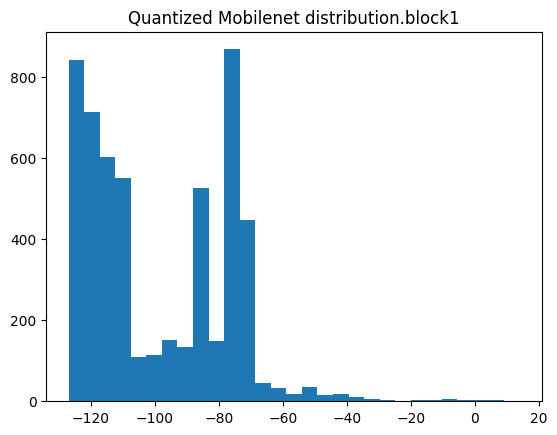

In [23]:
x = torch.flatten(q_output_activation['block1.2'])
x = x.cpu()
x = torch.flatten(x)
x = x.detach()
x = x.numpy()
print(x.shape)

plt.title("Quantized Mobilenet distribution.block1")
plt.hist(x, bins='auto',density=False)

# Golden generation

In [9]:
## ifmap ##
f = open('data_and_golden\main0.hex', 'w')
for i,data in enumerate(byte0):
    f.write(data+"\n")
f.close()
##
f = open('data_and_golden\main1.hex', 'w')
for i,data in enumerate(byte1):
    f.write(data+"\n")
f.close()
##
f = open('data_and_golden\main2.hex', 'w')
for i,data in enumerate(byte2):
    f.write(data+"\n")
f.close()
##
f = open('data_and_golden\main3.hex', 'w')
for i,data in enumerate(byte3):
    f.write(data+"\n")
f.close()

## weight ##

f = open('data_and_golden\weight0.hex', 'w')
for i,data in enumerate(weight_byte0):
    f.write(data+"\n")
f.close()
##
f = open('data_and_golden\weight1.hex', 'w')
for i,data in enumerate(weight_byte1):
    f.write(data+"\n")
f.close()
##
f = open('data_and_golden\weight2.hex', 'w')
for i,data in enumerate(weight_byte2):
    f.write(data+"\n")
f.close()
##
f = open('data_and_golden\weight3.hex', 'w')
for i,data in enumerate(weight_byte3):
    f.write(data+"\n")
f.close()
############

############
## Golden ##
f = open('data_and_golden\golden.hex', 'w')
for i,data in enumerate(golden):
    print(*data,sep='',file=f)
f.close()

## input gen with 0x 32bits ##
f = open('data_and_golden\data.hex', 'w')
for i,data in enumerate(input_with_0x ):
    print(*data ,sep='',file=f)
f.close()

NameError: name 'byte0' is not defined